### Read a portion of the National Land Cover Database in tif format

It easy to pull the NLCD for a region using GlobalMapper. I saved it as an 8-bit  palette image with no resampling.

You could also pull it in directly using the Ecohydrolib package:
    
http://pythonhosted.org/ecohydrolib/namespaceecohydrolib_1_1nlcd_1_1daacquery.html

In [21]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
%matplotlib inline
from pyproj import Proj, transform

# read in the nlcd classifications as an array
with rasterio.open("nlcd2011_fireisland_8bitpalette.tif") as lc:
    z = lc.read(1)
    
print("shape of the array is",np.shape(z))

# coordinate reference system
print("Info on the coordinate reference system:")
print(lc.crs)
# data transform
print(lc.transform)

# convert from array index to coordinate units
# upper left corner
ul = lc.transform*(0,0)
# lower right corner
lr = lc.transform*(lc.width, lc.height)
print('upper left: ',ul)
print('lower right: ',lr)

# convert corners to lat/lon
inProj = Proj(init='epsg:3395')  # World mercator
outProj = Proj(init='epsg:4326') # WGS84 lat/lon
#x1,y1 = ul[0],ul[1]
print("upper left lat/lon: ",transform(inProj,outProj,ul[0],ul[1]))
print("lower right lat/lon: ",transform(inProj,outProj,lr[0],lr[1]))
print("Here is a snippet of the array")
z

shape of the array is (523, 945)
Info on the coordinate reference system:
CRS({'init': 'epsg:3395'})
| 38.22, 0.00,-8146622.73|
| 0.00,-38.22, 4953295.80|
| 0.00, 0.00, 1.00|
upper left:  (-8146622.732239693, 4953295.800723135)
lower right:  (-8110506.236374948, 4933307.517826561)
upper left lat/lon:  (-73.18235714326453, 40.788637393225294)
lower right lat/lon:  (-72.85791714082312, 40.65202326338797)
Here is a snippet of the array


array([[23, 22, 22, ..., 22, 22, 22],
       [23, 22, 22, ..., 23, 23, 23],
       [23, 23, 22, ..., 24, 24, 23],
       ..., 
       [11, 11, 11, ...,  0,  0,  0],
       [11, 11, 11, ...,  0,  0,  0],
       [11, 11, 11, ...,  0,  0,  0]], dtype=uint8)

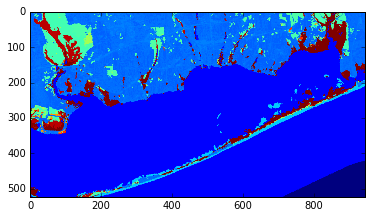

In [22]:
plt.imshow(z)

### Make a dict to convert from NLCD number to Manning's n and Surface roughness length

The friction factor used in the model to calculate bottom stress, where ${\tau}_b = C_fU|U|$ is related to Manning's n as $C_f = gn^2/h^{1/3}$

Mattocks, C., Forbes, C., 2008. A real-time, event-triggered storm surge forecasting system for the state of North Carolina. Ocean Modelling 25, 95–119. https://doi.org/10.1016/j.ocemod.2008.06.008

Mattocks, C., Forbes, C., Ran, L., 2006. Design and implementation of a real-time storm surge and ﬂood forecasting capability for the State of North Carolina. UNC–CEP Technical Report, November 30, 2006, 103 pp.

![From Mattocks and Forbes (2008)](./nlcd_to_roughness.png)
    

In [31]:
# make the dict...use 0.02 for missing values
n = {11:0.02,12:0.10,21:0.02,22:0.05,23:0.10,24:0.15,\
     31:0.09,32:0.04,41:0.10,42:0.11,43:0.10,51:0.04,\
     52:0.05,71:0.034,72:0.03,73:0.027,74:0.025,81:0.033,\
     82:0.037,90:0.10,91:0.10,92:0.048,93:0.10,94:0.048,\
     95:0.045,96:0.045,97:0.045,98:0.015,99:0.015,\
     0:0.02}
len(n)

30

In [24]:
n[11]

0.02

In [32]:
nmap = np.zeros_like(z)
(ni,nj)=np.shape(z)
for i in range(ni):
    for j in range(nj):
        nmap[i,j]=n[z[i][j]]